# Selection of batch size for training

To study the effect of batch size on the accuracy of the ResNet18 model and choose the optimal value.

* [The parameters studied](#The-parameters-studied)
* [Metrics](#Metrics)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)


## The parameters studied
Batch size: [20, 50, 100].

## Metrics
The metric is MSE (mean squared error) on the test and on the training part of the dataset.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import Dataset, B, V, C, Pipeline
from batchflow.models.tf import ResNet18
from batchflow.research import Research, Option, Results

from src import ShapesBatch, show_samples, show_research, get_mse

Dataset allocation

In [2]:
imset = Dataset(1000, ShapesBatch)

## Creating a model template

Model configuration:

In [3]:
model_config={'inputs/images/shape': B("image_shape"),
              'inputs/labels/shape': 2,
              'initial_block/inputs': 'images',
              'loss': 'mse',
              'optimizer': 'Adam'
             }

Create training and test pipelines

In [4]:
train_template = (Pipeline()                                     
                  .init_variable('current_loss')
                  .init_model('dynamic', ResNet18, 'resnet', config=model_config)
                  .sample_images(128, max_r=24)
                  .train_model('resnet', fetches='loss', images=B('images'), labels=B('labels'),
                               save_to=V('current_loss'))
                  .run(C('batch_size'), n_epochs=None, lazy=True))

predict_template = (Pipeline()
                   .import_model('resnet', C('import_from'))
                   .init_variable('predictions', init_on_each_run=list)
                   .init_variable('targets', init_on_each_run=list)
                   .sample_images(128, max_r=24)
                   .update(V('targets', mode='e'), B('labels'))
                   .predict_model('resnet', fetches='predictions', images=B('images'), labels=B('labels'),
                                  save_to=V('predictions', mode='e'))
                   .run(20, n_epochs=1, lazy=True))

## Creating a research object

Set the parameters for `research` execution:

For each parameter set perform NUM_ITERS=50 iterations of train pipeline with model performance evaluation every 10 iterations. Repeat this procedure NUM_REPEAT=1 times.

In [5]:
train_ppl = (train_template << imset)
test_ppl = (predict_template << imset)

opts = Option('batch_size', [20, 50, 100])

research = (Research()
            .add_pipeline(train_ppl, variables='current_loss', name='train')
            .add_pipeline(test_ppl, execute=10, name='predict', run=True, import_from='train')
            .add_function(get_mse, returns='metrics', name='test',
                      execute=10, pipeline='predict')
            .add_grid(opts))

Run `research`:

In [6]:
research.run(n_reps=1, n_iters=50, name='parameters_research', bar=True, workers=1, gpu=[1, 2])

Research parameters_research is starting...


  0%|          | 0/150 [00:00<?, ?it/s]

Distributor has 3 jobs with 50 iterations. Totally: 150


100%|██████████| 150/150 [02:01<00:00,  1.24it/s]


Load `research` results to pandas DataFrame

In [7]:
df = research.load_results(use_alias=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 4
Data columns (total 6 columns):
config          165 non-null object
current_loss    150 non-null float64
iteration       165 non-null int64
metrics         15 non-null float64
name            165 non-null object
repetition      165 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 9.0+ KB


## Results

Loss functions vs a number of iterations for each `batch_size` value:

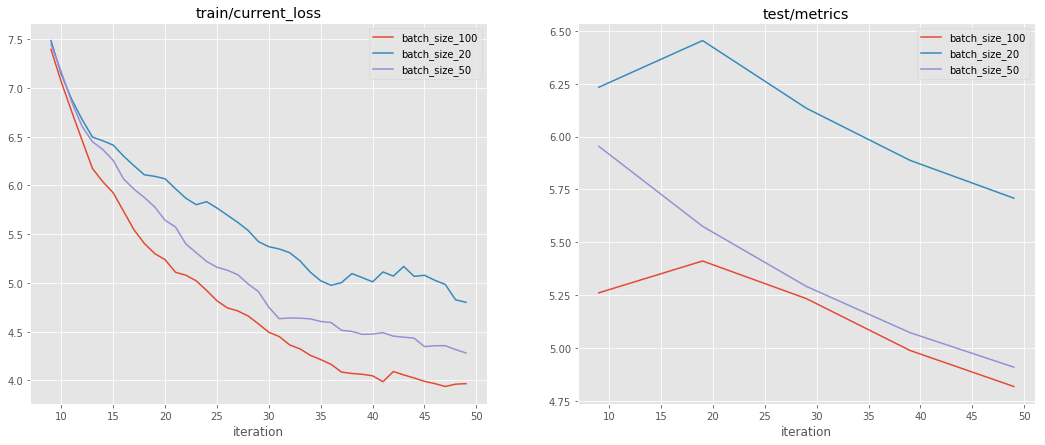

In [8]:
show_research(df, layout=['train/current_loss', 'test/metrics'],
              average_repetitions=True, log_scale=[True, True],
              rolling_window=[10, None])

# Conclusion

It can be concluded that a larger batch size provides more stable convergence and better accuracy of the model.